In [1]:
import pandas as pd
import numpy as np
from my_pysyncon import Dataprep, AugSynthGPT

In [2]:
# import the data

df_mo = pd.read_csv('../../../SharedData/total_state_data.csv')
df_yr = pd.read_csv('../../../SharedData/yearly_total_data.csv')

In [3]:
df_mo.columns

Index(['state', 'state_sq_ft', 'year', 'month', 'date', 'monthly_population',
       'yearly_population', 'monthly_pop_density', 'yearly_pop_density',
       'monthly_emissions', 'prcp', 'snow', 'tavg', 'gdp_rel_2017',
       'gdp_rel_2017_interp', 'yearly_gdp_rel_2017', 'monthly_energy_prod',
       'yearly_energy_prod', 'monthly_energy_use', 'yearly_energy_use',
       'monthly_energy_flow', 'yearly_energy_flow', 'monthly_num_plants',
       'yearly_num_plants', 'total_facility_age', 'monthly_energy_total',
       'yearly_energy_total', 'monthly_energy_renew', 'yearly_energy_renew',
       'monthly_renew_pct', 'yearly_renew_pct', 'monthly_energy_fossil',
       'yearly_energy_fossil', 'monthly_fossil_pct', 'yearly_fossil_pct',
       'republican_vote_pct'],
      dtype='object')

In [4]:
# this list is used to make certain columns later

abbreviations = [
    "AL", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]

In [5]:
#df_mo['date'] = pd.to_datetime(df_mo['date'])

# add a bunch of features (these will eventually get moved to combine_files.ipynb)

df_mo['co2_per_capita'] = df_mo['monthly_emissions'] / df_mo['monthly_population']
df_mo['gdp_per_capita'] = df_mo['gdp_rel_2017_interp'] / df_mo['monthly_population']
df_mo['eprod_per_capita'] = df_mo['monthly_energy_prod'] / df_mo['monthly_population']
df_mo['eflow_per_capita'] = df_mo['monthly_energy_flow'] / df_mo['monthly_population']
df_mo['euse_per_capita'] = df_mo['monthly_energy_use'] / df_mo['monthly_population']
df_mo['avg_facility_age'] = df_mo['total_facility_age']/df_mo['monthly_num_plants']


sma_feature_list = ['monthly_pop_density', 'yearly_pop_density',
       'monthly_emissions', 'prcp', 'snow', 'tavg',
       'gdp_rel_2017', 'gdp_rel_2017_interp', 'yearly_gdp_rel_2017',
       'monthly_energy_prod', 'yearly_energy_prod', 'monthly_energy_use',
       'yearly_energy_use', 'monthly_energy_flow', 'yearly_energy_flow',
       'monthly_num_plants', 'yearly_num_plants', 'total_facility_age',
       'monthly_energy_total', 'yearly_energy_total', 'monthly_energy_renew',
       'yearly_energy_renew', 'monthly_renew_pct', 'yearly_renew_pct',
       'monthly_energy_fossil', 'yearly_energy_fossil', 'monthly_fossil_pct',
       'yearly_fossil_pct', 'co2_per_capita',
       'gdp_per_capita', 'eprod_per_capita', 'eflow_per_capita',
       'euse_per_capita', 'avg_facility_age']

# create column for simple moving avg of co2_per_capita; ma_window is the moving average window size (n=1 corresponds to usual monthly results)

df_mo['co2_per_capita_sma']= np.nan
ma_window = 12

for feature in sma_feature_list:
    for state in abbreviations:
        df_mo.loc[df_mo.state==state,feature+str('_sma')] = df_mo.loc[df_mo.state==state,feature].rolling(window=ma_window).mean()


df_yr['co2_per_capita'] = df_yr['yearly_emissions'] / df_yr['yearly_population']
df_yr['gdp_per_capita'] = df_yr['yearly_gdp_rel_2017'] / df_yr['yearly_population']
df_yr['eprod_per_capita'] = df_yr['yearly_energy_prod'] / df_yr['yearly_population']
df_yr['eflow_per_capita'] = df_yr['yearly_energy_flow'] / df_yr['yearly_population']
df_yr['euse_per_capita'] = df_yr['yearly_energy_use'] / df_yr['yearly_population']

In [6]:
df_mo[(df_mo.state=='AR') & (df_mo.republican_vote_pct.notna())].republican_vote_pct

1175     19.91
3479     26.35
4631     10.55
6935     23.05
8087     11.02
11543     9.65
13847    11.30
14999    14.94
17303    33.26
Name: republican_vote_pct, dtype: float64

In [7]:
treatment_date = '2009-01-01'
preintervention_ma_start_date = str((pd.to_datetime('1990-06-01')+ pd.DateOffset(months=ma_window-1)).strftime('%Y-%m-%d'))

# these are the time values where CO2 per capita is fit
preintervention_time_range = df_mo.date[(df_mo.date >= '1990-06-01')&(df_mo.date<treatment_date)&(df_mo.state=='MI')]

# these are dates that Jared is testing to see if other time subsets give better fits


# these are the time values where our features are fit (subset of preintervention_time_range)
preintervention_feature_range = df_mo.date[(df_mo.date >= '1990-01-01') & (df_mo.date<treatment_date)&(df_mo.state=='MI')]
preintervention_weather_range = df_mo.date[(df_mo.date >= '1990-01-01') & (df_mo.date<treatment_date)&(df_mo.state=='MI')]
preintervention_gdp_range = df_mo.date[(df_mo.date >= '1997-12-01') & (df_mo.date<treatment_date)&(df_mo.state=='MI')]
preintervention_per_capita_range = df_mo.date[(df_mo.date >= '1990-06-01') & (df_mo.date<treatment_date)&(df_mo.state=='MI')]
preintervention_energy_range = df_mo.date[(df_mo.date >= '1990-12-01') & (df_mo.date<treatment_date)&(df_mo.state=='MI')]
preintervention_ma_range = df_mo.date[(df_mo.date >= preintervention_ma_start_date) & (df_mo.date<treatment_date)&(df_mo.state=='MI')]


# these are the dates used for our monthly_emissions graph
years = pd.date_range(start='1990-06-01', end='2019-12-01', freq='MS').strftime('%Y-%m-%d').tolist()

# these are the dates used for our monthly_emissions SMA graph
years_sma = pd.date_range(start=preintervention_ma_start_date, end='2019-12-01', freq='MS').strftime('%Y-%m-%d').tolist()

In [8]:
# we leave off RGGI states;
# states with no CO2 data (AK, HI);
# states with some type of emissions program (CA, WA, OR, MN);
# and states with very high CO2 per capita (WY, ND, WV, LA)

rggi_states = ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NJ', 'NY', 'RI', 'VT', 'VA']

non_rggi_controls_identifier= [
    "AL", 
    #"AK", 
    "AZ", "AR", 
    #"CA", 
    "CO", 
    #"CT", 
    #"DE", 
    "FL", 
    "GA",
    #"HI", 
    "ID", "IL", "IN", "IA", "KS", "KY", 
    #"LA", 
    #"ME", 
    #"MD",
    #"MA", 
    "MI", 
    #"MN", 
    "MS", "MO", "MT", "NE", "NV", 
    #"NH", 
    #"NJ",
    "NM", "NC", 
    #"ND", 
    "OH", "OK", 
    #"OR", 
    "PA", 
    #"RI", 
    "SC", "SD", "TN", 
    "TX", 
    "UT", 
    #"VT", 
    #"VA", 
    #"WA", 
    #"WV", 
    "WI", 
    #"WY"
    ]

In [9]:
# these lists are used for treatment_time in graphs below

treatment_dates = []
for year in years:
    if year.startswith('2009'):
        treatment_dates.append(year)

treatment_dates_ma = []
for year in years_sma:
    if year.startswith('2009'):
        treatment_dates_ma.append(year)

In [10]:
preintervention_ma_range_dt = pd.to_datetime(preintervention_ma_range)

In [11]:
def date_to_str(date):
    return date.dt.strftime('%Y-%m-%d')

CO    0.178
KS    0.280
MI    0.169
NV    0.427
PA    0.271
Name: weights, dtype: float64
0.010085509545078973


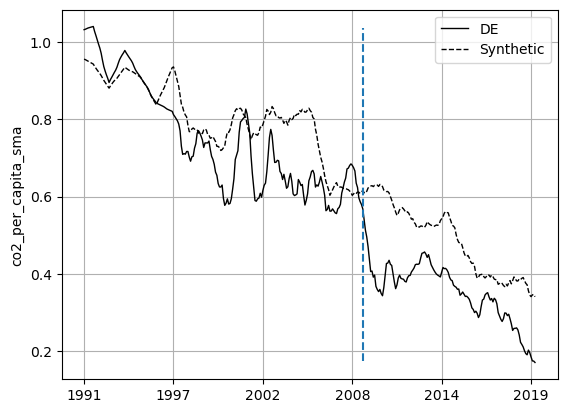

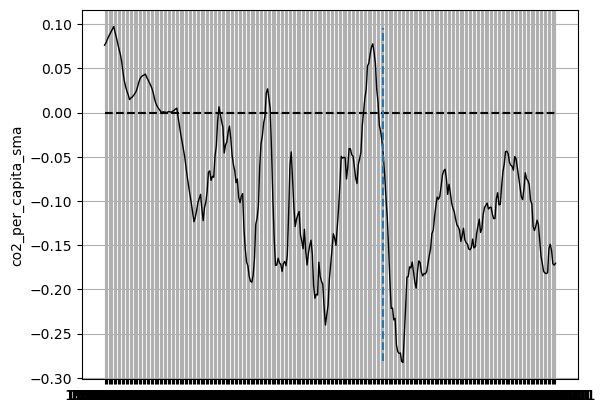

In [12]:
# we create a synthetic control Delaware as applied to monthly_emissions SMA data

dataprep_mo_ma = Dataprep(
    foo=df_mo,
    predictors=[],
    predictors_op="mean",
    time_predictors_prior=preintervention_ma_range,
    special_predictors=[
        ('avg_facility_age_sma',date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=1991)&(preintervention_ma_range_dt.dt.year <=2008)]), 'mean'),
        ('snow_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=1991)&(preintervention_ma_range_dt.dt.year <=2008)&(preintervention_ma_range_dt.dt.month ==1)]), 'mean'),
        ('tavg_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=1991)&(preintervention_ma_range_dt.dt.year <=2008)&(preintervention_ma_range_dt.dt.month ==7)]),'mean'),
        ('co2_per_capita_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year>=2007)&(preintervention_ma_range_dt.dt.year <=2008)]), 'mean'),         
        ('monthly_pop_density_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year>=1991) & (preintervention_ma_range_dt.dt.year<=2008)]), "mean"),        
        ('eprod_per_capita_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=1991)&(preintervention_ma_range_dt.dt.year <=2008)]), 'mean'),        
        ('gdp_per_capita_sma',  date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year>=2007)& (preintervention_ma_range_dt.dt.year<=2008)]), 'std'),
        ('monthly_fossil_pct_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=1991)&(preintervention_ma_range_dt.dt.year <=2008)]), 'mean'),
        #('republican_vote_pct', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=2004)&(preintervention_ma_range_dt.dt.year <=2008)&(preintervention_ma_range_dt.dt.month ==12)]), 'mean'), 
        #('euse_per_capita_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=2007)&(preintervention_ma_range_dt.dt.year <=2008)]), 'mean'),
        ],
    dependent="co2_per_capita_sma",
    unit_variable="state",
    time_variable="date",
    treatment_identifier="DE",
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=preintervention_ma_range
    )
# monthly_emissions SMA version

synth_mo_ma = AugSynthGPT()
synth_mo_ma.fit(dataprep=dataprep_mo_ma,lambda_=.1 ) # lambda_=1
print(synth_mo_ma.weights(threshold=.1))
print(synth_mo_ma.mspe(Z0=synth_mo_ma.Z0, Z1 = synth_mo_ma.Z1))
#print(synth_mo_ma.loss_W)

synth_mo_ma.path_plot(time_period=years_sma, treatment_time=treatment_dates_ma[0])
synth_mo_ma.gaps_plot(time_period=years_sma, treatment_time=treatment_dates_ma[0])

AZ    0.044
CO    0.086
FL    0.119
GA    0.014
ID    0.026
IL    0.981
MI    0.050
NV    0.076
NM    0.037
NC    0.048
PA    0.137
SD    0.042
TX    0.225
WI    0.031
Name: weights, dtype: float64
0.3045067037582552


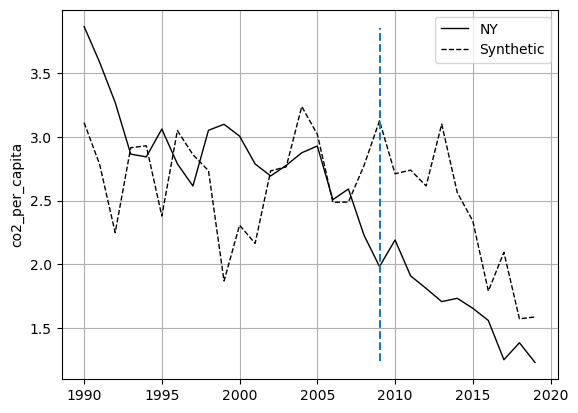

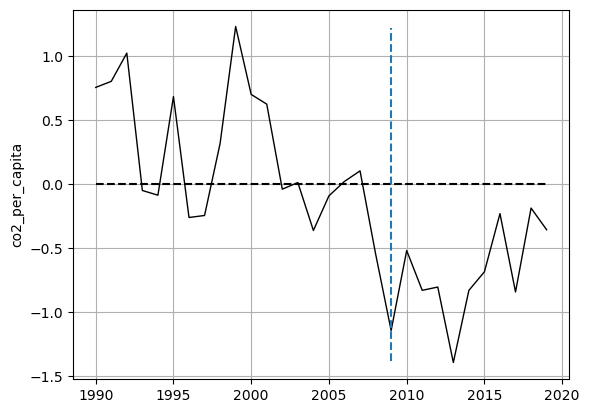

In [13]:
# we create a synthetic control Delaware as applied to yearly data

dataprep_yr = Dataprep(
    foo=df_yr,
    predictors=[],
    predictors_op="mean",
    time_predictors_prior=range(1997,2009),
    special_predictors=[
        ('co2_per_capita', range(2007,2009), "mean"),
        ('yearly_num_plants', range(1997,2009), "max"),
        ('eprod_per_capita', range(1990,2009), "mean"),
        ('eflow_per_capita', range(1990,2009), "mean"),
        ('gdp_per_capita', range(1997,2009), "mean"),
        ('yearly_pop_density', range(1990,2009), "mean"),
        #('yearly_renew_pct', range(1990,2009), "mean"),
        ('yearly_fossil_pct', range(1990,2009), "mean")
        ],
    dependent="co2_per_capita",
    unit_variable="state",
    time_variable="year",
    treatment_identifier="NY",
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=range(1990,2009)
)

# yearly version

synth_yr= AugSynthGPT()
synth_yr.fit(dataprep=dataprep_yr, lambda_=1)
print(synth_yr.weights(threshold=.01))
print(synth_yr.mspe(Z0=synth_yr.Z0, Z1 = synth_yr.Z1))
#print(synth_mo.loss_W)

# Yearly synthetic control plot

synth_yr.path_plot_orig(time_period=range(1990,2020), treatment_time=2009)
synth_yr.gaps_plot(time_period=range(1990,2020), treatment_time=2009)

In [14]:
synth_mo_ma.summary()

,treated,synthetic,sample mean
special.1.avg_facility_age_sma,59.091,59.107,62.134
special.2.snow_sma,0.878,0.876,1.270
special.3.tavg_sma,56.782,56.781,57.627
special.4.co2_per_capita_sma,0.617,0.618,1.007
special.5.monthly_pop_density_sma,0.003,0.003,0.028
special.6.eprod_per_capita_sma,0.000,0.000,0.023
special.7.gdp_per_capita_sma,0.000,0.000,0.000
special.8.monthly_fossil_pct_sma,0.966,0.965,0.723


In [15]:
synth_yr.summary()

,treated,synthetic,sample mean
special.1.co2_per_capita,2.411,2.631,12.000
special.2.yearly_num_plants,83.000,81.909,28.207
special.3.eprod_per_capita,0.032,0.078,0.279
special.4.eflow_per_capita,-0.168,-0.218,-0.080
special.5.gdp_per_capita,0.065,0.065,0.046
special.6.yearly_pop_density,0.003,0.003,0.029
special.7.yearly_fossil_pct,0.544,0.544,0.723
